In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

import h2o
import seaborn as sns
sys.path.insert(0, '..')
from DataModule.Data_Preparation import DRP_Dataset

from sklearn import metrics
import matplotlib
matplotlib.__version__

'3.5.3'

In [232]:
def responseClassify_binary(row, baseline, _next):
    # set threshold
    lower_change = 0.6
    upper_change = 1.2

    change = row[_next]
    row[_next] = row[baseline] - change

    if change <= lower_change:
        return "Nonresponder"

    elif (change <= upper_change) & (change > lower_change):
        if row[_next] > 5.1:
            return "Nonresponder"
        else:
            return "Responder"

    elif change > upper_change:
        if row[_next] > 3.2:
            return "Responder"
        else:
            return "Responder"

    else:
        return 2
    
def MSE(true, pred):
    return metrics.mean_squared_error(true, pred)
    
def Classification_Accuracy(true, pred):
    return metrics.accuracy_score(true, pred)

def R2(true, pred):
    return metrics.r2_score(true, pred)

def Adjusted_R2(true, pred, p):
    n = len(true)
    return 1-((1-R2(true,pred))*(n-1))/(n-p-1)

def F1_Score(true, pred):
    return metrics.f1_score(true, pred, average='macro')

def RPT(stability,performance,beta=1):
    return (beta**2+1)*stability*performance / (beta**2*stability+performance)

def calculate_RPT(row, metrics):
    stability = row[f'{metrics}_std']
    performance = row[f'{metrics}_mean']
    if metrics == 'mse':
        performance = 1 / performance
        stability = 1 / stability
    return RPT(stability,performance,beta=1)

def add_model_family(row):
    if "StackedEnsemble" in row['model_id']:
        if ("SelectedModels" in row['model_id']) & (len(list(row['ensemble'].split('+')))>3):
            return "StackedEnsemble_AllModels"
        
        else:
            return '_'.join(row['model_id'].split('_',3)[:2])
    else:
        return row['model_id'].split('_')[0]
    
def model_family_abbre(row):
    if row['model_family'] == "StackedEnsemble_AllModels":
        return "SE_All"
    elif row['model_family'] == "StackedEnsemble_BestOfFamily":
        return "SE_Best"
    elif row['model_family'] == "DeepLearning":
        return "ANN"
    elif row['model_family'] == "XGBoost":
        return "XGB"
    else:
        return row['model_family']

In [261]:
# df = pd.read_csv('./leaderboard/SC_regression_Aug3_final_output.csv')
df = pd.read_csv('./leaderboard_new/regression_Sep7_all_data_2_output.csv')
df

,challenge,imputation,model_id,model_family,ensemble,metalearner,test_mse,test_pc,binary_test_acc,binary_test_F1,3class_test_acc,3class_test_F1,mse_mean,r2_mean,mse_std,r2_std
0,regression_delta,KNN,StackedEnsemble_AllModels_6_AutoML_1_20220908_...,StackedEnsemble_AllModels,ALL,glm,1.296693,0.415572,0.725000,0.675641,0.491667,0.465618,1.204461,0.200429,0.264426,0.193909
1,regression_delta,KNN,StackedEnsemble_Best1000_1_AutoML_1_20220908_1...,StackedEnsemble_Best1000,ALL,glm,1.284120,0.410856,0.725000,0.675641,0.491667,0.466667,1.244088,0.205882,0.259970,0.100646
2,regression_delta,KNN,StackedEnsemble_BestOfFamily_7_AutoML_1_202209...,StackedEnsemble_BestOfFamily,ALL,glm,1.176126,0.450350,0.733333,0.673304,0.508333,0.476024,1.133467,0.188810,0.367808,0.159828
3,regression_delta,KNN,StackedEnsemble_BestOfFamily_4_AutoML_1_202209...,StackedEnsemble_BestOfFamily,ALL,glm,1.212579,0.432374,0.758333,0.690911,0.483333,0.451069,1.228381,0.117357,0.319571,0.224744
4,regression_delta,KNN,StackedEnsemble_BestOfFamily_5_AutoML_1_202209...,StackedEnsemble_BestOfFamily,ALL,glm,1.185733,0.451068,0.750000,0.701531,0.558333,0.532154,1.218322,0.091876,0.231790,0.285998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,drf,1.506756,0.292269,0.708333,0.626961,0.441667,0.395947,1.417112,-0.064803,0.255701,0.265784
165,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DeepLearning+GBM+GLM,deeplearning,1.355593,0.332273,0.716667,0.605340,0.466667,0.393231,1.300164,0.094847,0.246953,0.278647
166,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,deeplearning,1.375768,0.309171,0.716667,0.619444,0.366667,0.242758,1.288838,0.130772,0.257845,0.209641
167,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DeepLearning+GBM+GLM,xgboost,1.587039,0.344352,0.700000,0.681366,0.441667,0.437044,1.729448,-0.148636,0.341775,0.335161


In [262]:
df.sort_values(by='mse_mean',ascending=True)[['model_id','model_family','mse_mean','mse_std','binary_test_acc','binary_test_F1']].head(20)

,model_id,model_family,mse_mean,mse_std,binary_test_acc,binary_test_F1
2,StackedEnsemble_BestOfFamily_7_AutoML_1_202209...,StackedEnsemble_BestOfFamily,1.133467,0.367808,0.733333,0.673304
0,StackedEnsemble_AllModels_6_AutoML_1_20220908_...,StackedEnsemble_AllModels,1.204461,0.264426,0.725000,0.675641
7,StackedEnsemble_AllModels_3_AutoML_1_20220908_...,StackedEnsemble_AllModels,1.216238,0.293824,0.708333,0.647356
4,StackedEnsemble_BestOfFamily_5_AutoML_1_202209...,StackedEnsemble_BestOfFamily,1.218322,0.231790,0.750000,0.701531
3,StackedEnsemble_BestOfFamily_4_AutoML_1_202209...,StackedEnsemble_BestOfFamily,1.228381,0.319571,0.758333,0.690911
6,StackedEnsemble_AllModels_4_AutoML_1_20220908_...,StackedEnsemble_AllModels,1.232612,0.357692,0.716667,0.669677
159,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,1.238049,0.282606,0.733333,0.681633
10,GLM_1_AutoML_1_20220908_172343,GLM,1.239133,0.304635,0.716667,0.619444
5,DeepLearning_grid_3_AutoML_1_20220908_172343_m...,DeepLearning,1.241435,0.360570,0.766667,0.748268
1,StackedEnsemble_Best1000_1_AutoML_1_20220908_1...,StackedEnsemble_Best1000,1.244088,0.259970,0.725000,0.675641


In [263]:
df.loc[:,'model_family'] = df.apply(lambda row:add_model_family(row),axis=1)
df.loc[:,'model_family'] = df.apply(lambda row:model_family_abbre(row),axis=1)
df

,challenge,imputation,model_id,model_family,ensemble,metalearner,test_mse,test_pc,binary_test_acc,binary_test_F1,3class_test_acc,3class_test_F1,mse_mean,r2_mean,mse_std,r2_std
0,regression_delta,KNN,StackedEnsemble_AllModels_6_AutoML_1_20220908_...,SE_All,ALL,glm,1.296693,0.415572,0.725000,0.675641,0.491667,0.465618,1.204461,0.200429,0.264426,0.193909
1,regression_delta,KNN,StackedEnsemble_Best1000_1_AutoML_1_20220908_1...,StackedEnsemble_Best1000,ALL,glm,1.284120,0.410856,0.725000,0.675641,0.491667,0.466667,1.244088,0.205882,0.259970,0.100646
2,regression_delta,KNN,StackedEnsemble_BestOfFamily_7_AutoML_1_202209...,SE_Best,ALL,glm,1.176126,0.450350,0.733333,0.673304,0.508333,0.476024,1.133467,0.188810,0.367808,0.159828
3,regression_delta,KNN,StackedEnsemble_BestOfFamily_4_AutoML_1_202209...,SE_Best,ALL,glm,1.212579,0.432374,0.758333,0.690911,0.483333,0.451069,1.228381,0.117357,0.319571,0.224744
4,regression_delta,KNN,StackedEnsemble_BestOfFamily_5_AutoML_1_202209...,SE_Best,ALL,glm,1.185733,0.451068,0.750000,0.701531,0.558333,0.532154,1.218322,0.091876,0.231790,0.285998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,SE_All,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,drf,1.506756,0.292269,0.708333,0.626961,0.441667,0.395947,1.417112,-0.064803,0.255701,0.265784
165,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DeepLearning+GBM+GLM,deeplearning,1.355593,0.332273,0.716667,0.605340,0.466667,0.393231,1.300164,0.094847,0.246953,0.278647
166,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,SE_All,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,deeplearning,1.375768,0.309171,0.716667,0.619444,0.366667,0.242758,1.288838,0.130772,0.257845,0.209641
167,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DeepLearning+GBM+GLM,xgboost,1.587039,0.344352,0.700000,0.681366,0.441667,0.437044,1.729448,-0.148636,0.341775,0.335161


In [264]:
selected_models = pd.DataFrame(columns = df.columns)
for model_family in df.model_family.unique():
    model_family_group = df[df.model_family == model_family]
    model_family_group = model_family_group.sort_values(by=f'mse_mean', ascending=True)[:3]
    selected_model = model_family_group.sort_values(by=f'mse_std', ascending=True).iloc[0,:]
    selected_models.loc[len(selected_models),:] = selected_model
selected_models = selected_models.sort_values(by=f'mse_mean', ascending=True).reset_index(drop=True)
selected_models = selected_models[selected_models.model_family != 'StackedEnsemble_Best1000']
selected_models

,challenge,imputation,model_id,model_family,ensemble,metalearner,test_mse,test_pc,binary_test_acc,binary_test_F1,3class_test_acc,3class_test_F1,mse_mean,r2_mean,mse_std,r2_std
0,regression_delta,KNN,StackedEnsemble_AllModels_6_AutoML_1_20220908_...,SE_All,ALL,glm,1.296693,0.415572,0.725,0.675641,0.491667,0.465618,1.204461,0.200429,0.264426,0.193909
1,regression_delta,KNN,StackedEnsemble_BestOfFamily_5_AutoML_1_202209...,SE_Best,ALL,glm,1.185733,0.451068,0.75,0.701531,0.558333,0.532154,1.218322,0.091876,0.23179,0.285998
2,regression_delta,KNN,GLM_1_AutoML_1_20220908_172343,GLM,NaN,NaN,1.267429,0.375106,0.716667,0.619444,0.458333,0.397631,1.239133,0.163596,0.304635,0.111173
4,regression_delta,KNN,DeepLearning_grid_2_AutoML_1_20220908_172343_m...,ANN,NaN,NaN,1.31915,0.398836,0.741667,0.695299,0.533333,0.50912,1.274316,0.112107,0.269704,0.220713
5,regression_delta,KNN,GBM_grid_1_AutoML_1_20220908_172343_model_12,GBM,NaN,NaN,1.222775,0.412999,0.725,0.60942,0.433333,0.363163,1.297468,0.121182,0.30467,0.12398
6,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DeepLearning+GBM+GLM,deeplearning,1.355593,0.332273,0.716667,0.60534,0.466667,0.393231,1.300164,0.094847,0.246953,0.278647
7,regression_delta,KNN,XGBoost_lr_search_selection_AutoML_1_20220908_...,XGB,NaN,NaN,1.206695,0.420741,0.758333,0.690911,0.491667,0.459139,1.304683,0.115083,0.309147,0.135536
8,regression_delta,KNN,DRF_1_AutoML_1_20220908_172343,DRF,NaN,NaN,1.265289,0.379961,0.733333,0.65357,0.466667,0.42754,1.358782,0.081365,0.344553,0.143092
9,regression_delta,KNN,XRT_1_AutoML_1_20220908_172343,XRT,NaN,NaN,1.26337,0.380594,0.75,0.664216,0.475,0.424514,1.373989,0.069254,0.342408,0.146046


In [265]:
selected_models[['model_id','model_family','metalearner','mse_mean','mse_std','binary_test_acc','binary_test_F1']]

,model_id,model_family,metalearner,mse_mean,mse_std,binary_test_acc,binary_test_F1
0,StackedEnsemble_AllModels_6_AutoML_1_20220908_...,SE_All,glm,1.204461,0.264426,0.725,0.675641
1,StackedEnsemble_BestOfFamily_5_AutoML_1_202209...,SE_Best,glm,1.218322,0.23179,0.75,0.701531
2,GLM_1_AutoML_1_20220908_172343,GLM,NaN,1.239133,0.304635,0.716667,0.619444
4,DeepLearning_grid_2_AutoML_1_20220908_172343_m...,ANN,NaN,1.274316,0.269704,0.741667,0.695299
5,GBM_grid_1_AutoML_1_20220908_172343_model_12,GBM,NaN,1.297468,0.30467,0.725,0.60942
6,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,deeplearning,1.300164,0.246953,0.716667,0.60534
7,XGBoost_lr_search_selection_AutoML_1_20220908_...,XGB,NaN,1.304683,0.309147,0.758333,0.690911
8,DRF_1_AutoML_1_20220908_172343,DRF,NaN,1.358782,0.344553,0.733333,0.65357
9,XRT_1_AutoML_1_20220908_172343,XRT,NaN,1.373989,0.342408,0.75,0.664216


In [266]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = pd.DataFrame(columns = df.columns)
    for model_family in df.model_family.unique():
        model_family_group = df[df.model_family == model_family]
        model_family_group = model_family_group.sort_values(by=f'{evaluation_metrics}_mean', ascending=True)[:3]
        selected_model = model_family_group.sort_values(by=f'{evaluation_metrics}_std', ascending=True).iloc[0,:]
        selected_models.loc[len(selected_models),:] = selected_model
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=True)
    selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    y = selected_models[f'{evaluation_metrics}_mean']
    x = selected_models['model_family']
    y_error = selected_models[f'{evaluation_metrics}_std']
   
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 1 else "#799FCB" for i in range(len(x))]
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)

    ax.set_ylim(0,max(y+y_error)+0.1)
    bars = ax.bar(x,y_1,color=colors)
        
    ax.set_xlabel('Model', fontsize=20)
    ax.set_ylabel(evaluation_metrics.upper(), fontsize=20)

    ax.bar_label(bars, label_type='center',color='white', fontsize=16, fontweight='bold')

    ax.errorbar(x, y, yerr=y_error,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
#     ax.yaxis.set_tick_params(labelsize=20)
    
#     plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=16, weight = 'bold')

    plt.setp(ax.get_xticklabels(), fontsize=16, weight = 'bold')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

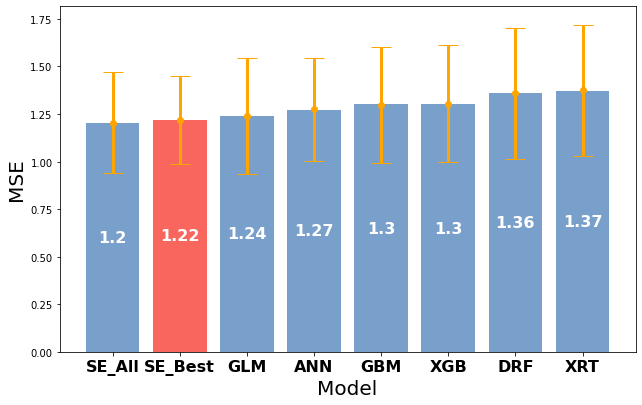

In [267]:
error_bar_plot(df, 'mse')

In [268]:
error_bar_plot(df, 'pc')

KeyError: 'pc_mean'

In [240]:
def bar_plot(df, evaluation_metrics):
    selected_models = pd.DataFrame(columns = df.columns)
    for model_family in df.model_family.unique():
        model_family_group = df[df.model_family == model_family]
        model_family_group = model_family_group.sort_values(by=f'mse_mean', ascending=True)[:3]
        selected_model = model_family_group.sort_values(by=f'mse_std', ascending=True).iloc[0,:]
        selected_models.loc[len(selected_models),:] = selected_model
    selected_models = selected_models.sort_values(by=f'mse_mean', ascending=True)
    selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    y = selected_models[evaluation_metrics]
    x = selected_models['model_family']    
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    
    ax.set_xlabel('Model', fontsize=20)
    ax.set_ylabel(evaluation_metrics.upper(), fontsize=20)

    colors = ["#F9665E" if i == 1 else "#799FCB" for i in range(len(x))]
    if evaluation_metrics == 'test_mse' or evaluation_metrics == 'test_pc':
        bars = ax.bar(x, y_1, color=colors)
    else:
        bars = ax.bar(x, y_perc, color=colors)
        
    ax.bar_label(bars, label_type='center',color='white', fontsize=16, fontweight='bold')
    
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=16, weight = 'bold')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

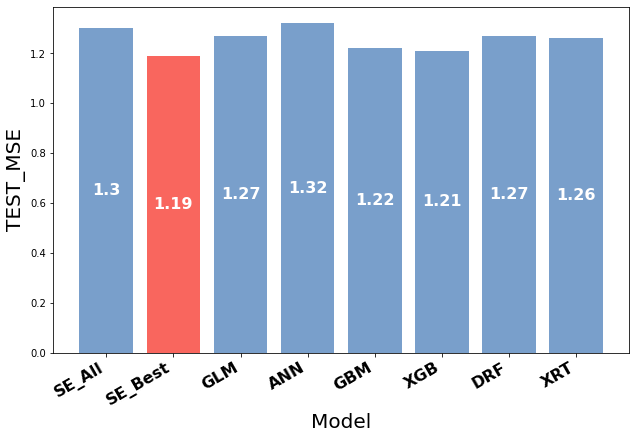

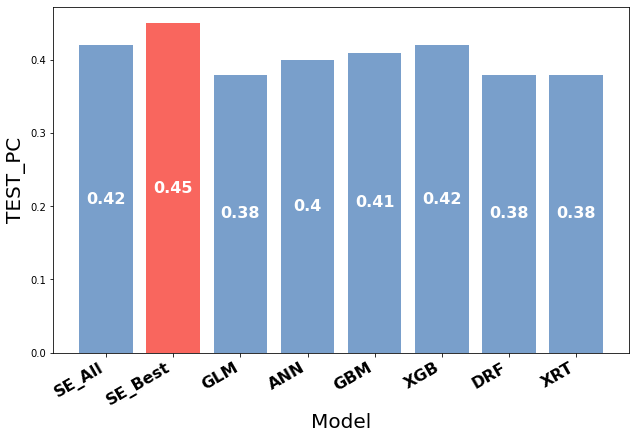

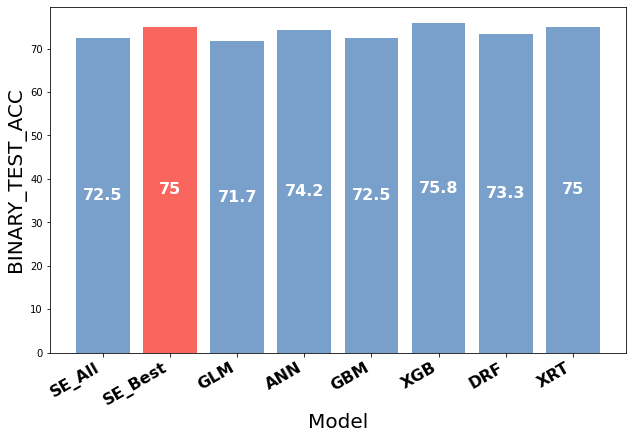

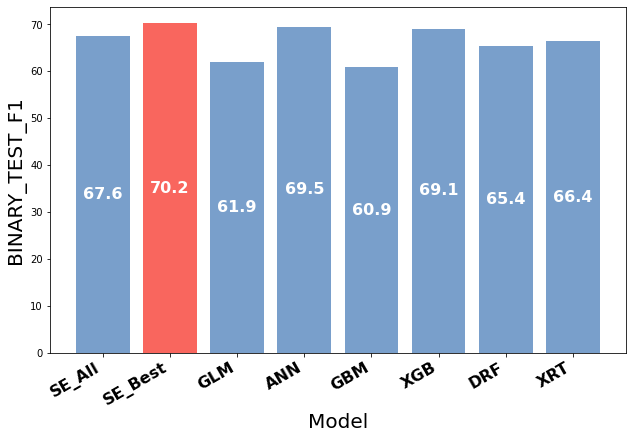

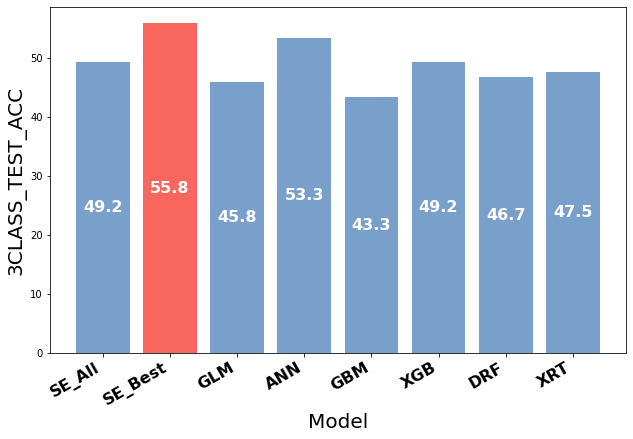

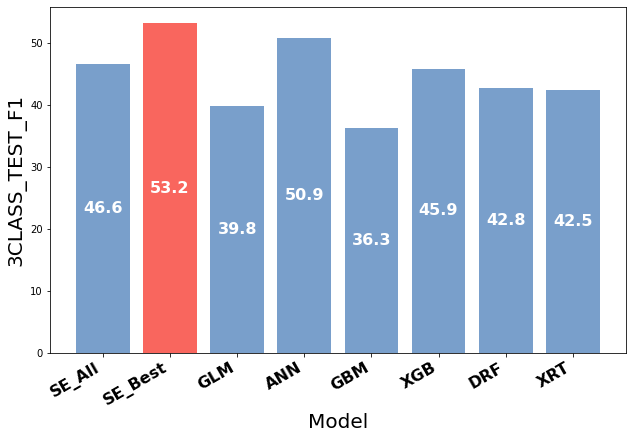

In [241]:
evaluation_metics_list = ['test_mse', 'test_pc', 'binary_test_acc', 'binary_test_F1', '3class_test_acc', '3class_test_F1']
for evaluation_metics in evaluation_metics_list:
    bar_plot(df, evaluation_metics)

In [174]:
dataset = DRP_Dataset(
    library_root = './Dataset/',
    challenge = "regression_delta", #option: regression_delta, 3_classification, binary_classification
    dataset = 'CORRONA CERTAIN', 
    imputation = "KNN", #option: SimpleFill, KNN, IterativeImputer, None(raw)
    patient_group = "bionaive TNF", #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.7,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
# train_h2o = h2o.upload_file(str(train_loc))
# test_h2o = h2o.upload_file(str(test_loc))
train_h2o = h2o.import_file(str(train_loc))
test_h2o = h2o.import_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = dataset.target

for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
if "classification" in dataset.challenge:
    train_h2o[y] = train_h2o[y].asfactor()
    test_h2o[y] = test_h2o[y].asfactor()

categorical features: ['UNMC_id', 'grp', 'init_group', 'CDate', 'gender', 'final_education', 'race_grp', 'newsmoker', 'drinker', 'ara_func_class']
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 42 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,2 months and 5 days
H2O_cluster_name:,H2O_from_python_gaskell_ut7qxp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.000 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [175]:
test

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,delta
0,0,0,62.0,1,0,7,1.0,219.0,28.114865,74.0,...,35.0,10.0,0.000000,10.0,4.41,284.0,1640.0,94.000000,3.444942,2.195426
1,1,0,54.0,0,2,7,1.0,160.0,26.622485,65.0,...,65.0,70.0,0.750000,60.0,51.51,462.0,939.0,49.000000,5.588392,0.934306
2,1,0,42.0,1,0,7,1.0,185.0,26.541837,70.0,...,39.0,35.0,0.000000,35.0,5.30,231.0,1340.0,118.000000,4.156756,2.638655
3,2,0,72.0,0,2,7,1.0,152.0,24.530762,66.0,...,50.0,65.0,0.857143,50.0,4.75,657.0,1480.0,317.000000,4.437767,-0.711757
4,1,0,61.0,0,2,7,1.0,145.0,26.517950,62.0,...,40.0,5.0,0.857143,60.0,1.31,164.0,902.0,72.000000,3.439129,0.369215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2,0,52.0,1,0,7,1.0,256.0,32.864865,74.0,...,25.0,30.0,0.000000,20.0,6.79,258.6,1180.7,95.133333,3.799023,1.434129
120,1,0,62.0,0,0,1,1.0,273.0,45.424615,65.0,...,60.0,20.0,0.428571,50.0,2.01,561.0,1410.0,198.000000,3.316698,0.520804
121,1,0,56.0,0,0,7,1.0,128.0,24.182747,61.0,...,70.0,60.0,0.142857,20.0,8.73,188.0,1320.0,138.000000,4.841508,1.842625
122,3,0,74.0,1,0,7,1.0,230.0,31.190201,72.0,...,65.0,25.0,0.000000,25.0,1.35,168.0,1360.0,69.000000,5.080998,2.579583


In [176]:
train

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,delta
0,1,0,61.0,0,0,7,1.0,240.0,39.933728,65.0,...,55.0,50.0,0.250000,60.0,1.000,44.000000,948.000000,51.000000,3.719481,-0.725467
1,1,0,64.0,1,0,7,1.0,294.0,41.000198,71.0,...,55.0,55.0,0.285714,70.0,16.740,178.000000,882.000000,87.000000,5.146565,2.300292
2,2,0,51.0,0,2,7,1.0,90.0,18.175812,59.0,...,65.0,20.0,0.250000,65.0,0.250,155.000000,824.000000,43.000000,4.425214,1.281229
3,3,0,57.0,0,0,7,1.0,161.0,30.417361,61.0,...,70.0,55.0,1.000000,65.0,8.591,273.000000,714.000000,138.000000,5.063897,3.542311
4,2,0,62.0,0,0,7,1.0,150.0,26.568405,63.0,...,50.0,25.0,0.000000,20.0,17.930,171.000000,992.000000,95.000000,5.278515,3.318235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,1,0,42.0,0,2,7,1.0,156.0,29.472722,61.0,...,55.0,80.0,1.000000,80.0,7.330,353.000000,859.000000,211.000000,5.167880,1.481994
285,2,0,49.0,0,0,1,1.0,220.0,33.447232,68.0,...,35.0,50.0,0.000000,15.0,22.360,266.000000,1330.000000,253.000000,4.272186,-0.186939
286,1,0,24.0,0,0,1,1.0,128.0,20.045444,67.0,...,75.0,60.0,0.500000,60.0,6.470,289.000000,1800.000000,188.000000,4.333871,2.224753
287,2,0,61.0,0,0,7,1.0,125.0,20.798817,65.0,...,35.0,15.0,0.000000,15.0,0.920,163.000000,1500.000000,44.000000,3.283134,2.235549


In [109]:
selected_models

,challenge,imputation,model_id,model_family,ensemble,metalearner,test_mse,test_pc,binary_test_acc,binary_test_F1,3class_test_acc,3class_test_F1,mse_mean,r2_mean,mse_std,r2_std
0,regression_delta,KNN,StackedEnsemble_AllModels_6_AutoML_1_20220908_...,StackedEnsemble_AllModels,ALL,glm,1.296693,0.415572,0.725,0.675641,0.491667,0.465618,1.204461,0.200429,0.264426,0.193909
1,regression_delta,KNN,StackedEnsemble_BestOfFamily_5_AutoML_1_202209...,StackedEnsemble_BestOfFamily,ALL,glm,1.185733,0.451068,0.75,0.701531,0.558333,0.532154,1.218322,0.091876,0.23179,0.285998
2,regression_delta,KNN,GLM_1_AutoML_1_20220908_172343,GLM,NaN,NaN,1.267429,0.375106,0.716667,0.619444,0.458333,0.397631,1.239133,0.163596,0.304635,0.111173
3,regression_delta,KNN,StackedEnsemble_Best1000_1_AutoML_1_20220908_1...,StackedEnsemble_Best1000,ALL,glm,1.28412,0.410856,0.725,0.675641,0.491667,0.466667,1.244088,0.205882,0.25997,0.100646
4,regression_delta,KNN,DeepLearning_grid_2_AutoML_1_20220908_172343_m...,DeepLearning,NaN,NaN,1.31915,0.398836,0.741667,0.695299,0.533333,0.50912,1.274316,0.112107,0.269704,0.220713
5,regression_delta,KNN,StackedEnsemble_SelectedModels_1_SC_1_20220908...,StackedEnsemble_SelectedModels,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,deeplearning,1.375768,0.309171,0.716667,0.619444,0.366667,0.242758,1.288838,0.130772,0.257845,0.209641
6,regression_delta,KNN,GBM_grid_1_AutoML_1_20220908_172343_model_12,GBM,NaN,NaN,1.222775,0.412999,0.725,0.60942,0.433333,0.363163,1.297468,0.121182,0.30467,0.12398
7,regression_delta,KNN,XGBoost_lr_search_selection_AutoML_1_20220908_...,XGBoost,NaN,NaN,1.206695,0.420741,0.758333,0.690911,0.491667,0.459139,1.304683,0.115083,0.309147,0.135536
8,regression_delta,KNN,DRF_1_AutoML_1_20220908_172343,DRF,NaN,NaN,1.265289,0.379961,0.733333,0.65357,0.466667,0.42754,1.358782,0.081365,0.344553,0.143092
9,regression_delta,KNN,XRT_1_AutoML_1_20220908_172343,XRT,NaN,NaN,1.26337,0.380594,0.75,0.664216,0.475,0.424514,1.373989,0.069254,0.342408,0.146046


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


challenge,imputation,model_id,model_family,ensemble,metalearner,test_mse,test_pc,binary_test_acc,binary_test_F1,3class_test_acc,3class_test_F1,mse_mean,r2_mean,mse_std,r2_std
regression_delta,KNN,StackedEnsemble_AllModels_6_AutoML_1_20220908_172343,StackedEnsemble_AllModels,ALL,glm,1.29669,0.415572,0.725,0.675641,0.491667,0.465618,1.20446,0.200429,0.264426,0.193909
regression_delta,KNN,StackedEnsemble_BestOfFamily_5_AutoML_1_20220908_172343,StackedEnsemble_BestOfFamily,ALL,glm,1.18573,0.451068,0.75,0.701531,0.558333,0.532154,1.21832,0.0918757,0.23179,0.285998
regression_delta,KNN,GLM_1_AutoML_1_20220908_172343,GLM,nan,nan,1.26743,0.375106,0.716667,0.619444,0.458333,0.397631,1.23913,0.163596,0.304635,0.111173
regression_delta,KNN,StackedEnsemble_Best1000_1_AutoML_1_20220908_172343,StackedEnsemble_Best1000,ALL,glm,1.28412,0.410856,0.725,0.675641,0.491667,0.466667,1.24409,0.205882,0.25997,0.100646
regression_delta,KNN,DeepLearning_grid_2_AutoML_1_20220908_172343_model_2,DeepLearning,nan,nan,1.31915,0.398836,0.741667,0.695299,0.533333,0.50912,1.27432,0.112107,0.269704,0.220713
regression_delta,KNN,GBM_grid_1_AutoML_1_20220908_172343_model_12,GBM,nan,nan,1.22277,0.412999,0.725,0.60942,0.433333,0.363163,1.29747,0.121182,0.30467,0.12398
regression_delta,KNN,XGBoost_lr_search_selection_AutoML_1_20220908_172343_select_grid_model_3,XGBoost,nan,nan,1.20669,0.420741,0.758333,0.690911,0.491667,0.459139,1.30468,0.115083,0.309147,0.135536
regression_delta,KNN,DRF_1_AutoML_1_20220908_172343,DRF,nan,nan,1.26529,0.379961,0.733333,0.65357,0.466667,0.42754,1.35878,0.0813645,0.344553,0.143092
regression_delta,KNN,XRT_1_AutoML_1_20220908_172343,XRT,nan,nan,1.26337,0.380594,0.75,0.664216,0.475,0.424514,1.37399,0.0692543,0.342408,0.146046


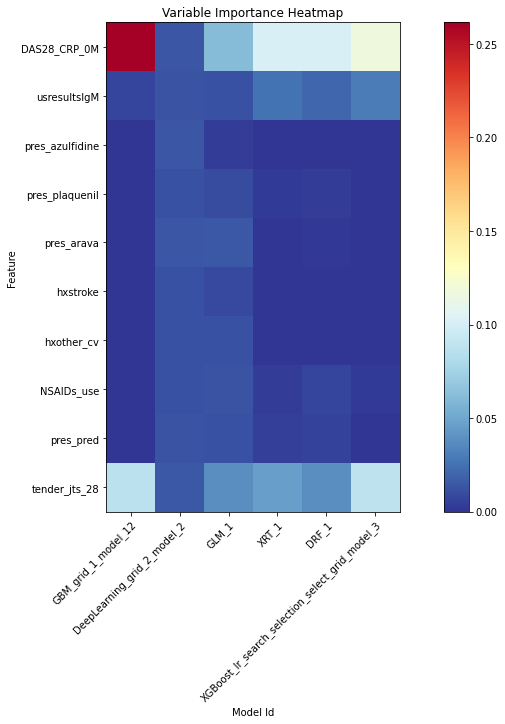

In [113]:
df_var = h2o.H2OFrame(selected_models[selected_models['model_family']!="StackedEnsemble_SelectedModels"])

for model in selected_models['model_id']:
    if "StackedEnsemble" in model:
        pass
    else:
        model_path = os.path.join('./leaderboard_new/leaderboard/model_saved/', model)
        h2o.upload_model(model_path)
    
print(df_var)
    
h2o.varimp_heatmap(df_var, test_h2o, num_of_features=10)

# Binary Classification

In [269]:
df = pd.read_csv('./leaderboard_new/binary_classification_Sep7_output.csv')
df

,challenge,imputation,model_id,model_family,ensemble,metalearner,test_acc,test_F1,test_auc,test_aucpr,...,mcc_std,mean_per_class_accuracy_std,mean_per_class_error_std,mse_std,pr_auc_std,precision_std,r2_std,recall_std,rmse_std,specificity_std
0,binary_classification,KNN,DeepLearning_grid_2_AutoML_1_20220909_04953_mo...,DeepLearning,NaN,NaN,0.608333,0.618903,0.636015,0.823928,...,0.091895,0.077328,0.077328,0.061918,0.093948,0.054291,0.247047,0.015789,0.066517,0.160720
1,binary_classification,KNN,XRT_1_AutoML_1_20220909_04953,XRT,NaN,NaN,0.741667,0.646794,0.638802,0.808300,...,0.070646,0.069619,0.069619,0.024787,0.060543,0.056133,0.118868,0.019048,0.029280,0.151477
2,binary_classification,KNN,GBM_grid_1_AutoML_1_20220909_04953_model_30,GBM,NaN,NaN,0.400000,0.379241,0.649948,0.822419,...,0.072229,0.071889,0.071889,0.033740,0.065318,0.056589,0.102152,0.019048,0.039576,0.156864
3,binary_classification,KNN,XGBoost_lr_search_selection_AutoML_1_20220909_...,XGBoost,NaN,NaN,0.725000,0.609420,0.579589,0.779535,...,0.056245,0.055286,0.055286,0.021771,0.059334,0.051873,0.031579,0.030000,0.026325,0.131810
4,binary_classification,KNN,DRF_1_AutoML_1_20220909_04953,DRF,NaN,NaN,0.716667,0.619444,0.632881,0.814642,...,0.030569,0.039635,0.039635,0.023542,0.051114,0.041016,0.081157,0.015789,0.027531,0.089137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,StackedEnsemble_SelectedModels,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,drf,0.725000,0.609420,0.607106,0.805407,...,0.109982,0.099508,0.099508,0.039433,0.068055,0.072282,0.226421,0.035759,0.044739,0.230754
194,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,StackedEnsemble_SelectedModels,DeepLearning+GBM+XGBoost,deeplearning,0.725000,0.609420,0.461163,0.678728,...,0.000000,0.056250,0.056250,0.075590,0.102954,0.078041,0.145211,0.000000,0.088993,0.112500
195,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,StackedEnsemble_SelectedModels,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,deeplearning,0.716667,0.605340,0.490770,0.743896,...,0.062215,0.040227,0.040227,0.071632,0.067065,0.053253,0.215971,0.015000,0.076526,0.086927
196,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,StackedEnsemble_SelectedModels,DeepLearning+GBM+XGBoost,xgboost,0.650000,0.622401,0.526994,0.711507,...,0.000000,0.015000,0.015000,0.057358,0.108617,0.089077,0.465665,0.000000,0.057651,0.030000


In [270]:
df.loc[:,'model_family'] = df.apply(lambda row:add_model_family(row),axis=1)
df.loc[:,'model_family'] = df.apply(lambda row:model_family_abbre(row),axis=1)
df

,challenge,imputation,model_id,model_family,ensemble,metalearner,test_acc,test_F1,test_auc,test_aucpr,...,mcc_std,mean_per_class_accuracy_std,mean_per_class_error_std,mse_std,pr_auc_std,precision_std,r2_std,recall_std,rmse_std,specificity_std
0,binary_classification,KNN,DeepLearning_grid_2_AutoML_1_20220909_04953_mo...,ANN,NaN,NaN,0.608333,0.618903,0.636015,0.823928,...,0.091895,0.077328,0.077328,0.061918,0.093948,0.054291,0.247047,0.015789,0.066517,0.160720
1,binary_classification,KNN,XRT_1_AutoML_1_20220909_04953,XRT,NaN,NaN,0.741667,0.646794,0.638802,0.808300,...,0.070646,0.069619,0.069619,0.024787,0.060543,0.056133,0.118868,0.019048,0.029280,0.151477
2,binary_classification,KNN,GBM_grid_1_AutoML_1_20220909_04953_model_30,GBM,NaN,NaN,0.400000,0.379241,0.649948,0.822419,...,0.072229,0.071889,0.071889,0.033740,0.065318,0.056589,0.102152,0.019048,0.039576,0.156864
3,binary_classification,KNN,XGBoost_lr_search_selection_AutoML_1_20220909_...,XGB,NaN,NaN,0.725000,0.609420,0.579589,0.779535,...,0.056245,0.055286,0.055286,0.021771,0.059334,0.051873,0.031579,0.030000,0.026325,0.131810
4,binary_classification,KNN,DRF_1_AutoML_1_20220909_04953,DRF,NaN,NaN,0.716667,0.619444,0.632881,0.814642,...,0.030569,0.039635,0.039635,0.023542,0.051114,0.041016,0.081157,0.015789,0.027531,0.089137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,SE_All,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,drf,0.725000,0.609420,0.607106,0.805407,...,0.109982,0.099508,0.099508,0.039433,0.068055,0.072282,0.226421,0.035759,0.044739,0.230754
194,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,StackedEnsemble_SelectedModels,DeepLearning+GBM+XGBoost,deeplearning,0.725000,0.609420,0.461163,0.678728,...,0.000000,0.056250,0.056250,0.075590,0.102954,0.078041,0.145211,0.000000,0.088993,0.112500
195,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,SE_All,DRF+DeepLearning+GBM+GLM+XGBoost+XRT,deeplearning,0.716667,0.605340,0.490770,0.743896,...,0.062215,0.040227,0.040227,0.071632,0.067065,0.053253,0.215971,0.015000,0.076526,0.086927
196,binary_classification,KNN,StackedEnsemble_SelectedModels_1_SC_1_model_5,StackedEnsemble_SelectedModels,DeepLearning+GBM+XGBoost,xgboost,0.650000,0.622401,0.526994,0.711507,...,0.000000,0.015000,0.015000,0.057358,0.108617,0.089077,0.465665,0.000000,0.057651,0.030000


In [271]:
def addlabels(ax,x,y):
    for i in range(len(x)):
        ax.text(i, (y[i]+50)//2, y[i], ha = 'center', color='white',fontsize=12)

In [272]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
    
#     x = list(df['model_id'])
#     y = df[f'{evaluation_metrics}_mean']
    y_1 = [round(a,2) for a in y]
#     y_error = df[f'{evaluation_metrics}_std']
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'accuracy':
        ax1.set_ylim(50,100)
        bars = ax1.bar(x,y_perc,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
    addlabels(ax1,x,y_perc)
#     ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Accuracy(%)', fontsize=20)
    
    ax1.errorbar(x, y_perc, yerr=y_error_perc,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
    

In [273]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = pd.DataFrame(columns = df.columns)
    for model_family in df.model_family.unique():
        model_family_group = df[df.model_family == model_family]
        model_family_group = model_family_group.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)[:3]
        selected_model = model_family_group.sort_values(by=f'{evaluation_metrics}_std', ascending=False).iloc[0,:]
        selected_models.loc[len(selected_models),:] = selected_model
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    y = selected_models[f'{evaluation_metrics}_mean']
    x = selected_models['model_family']
    y_error = selected_models[f'{evaluation_metrics}_std']
   
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
    y_error_perc = [a*100 for a in y_error]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)

    ax.set_ylim(50,100)
    addlabels(ax,x,y_perc)
    bars = ax.bar(x,y_perc,color=colors)
        
    ax.set_xlabel('Model', fontsize=20)
    ax.set_ylabel('Accuracy(%)', fontsize=20)

    ax.bar_label(bars, label_type='center',color='white', fontsize=16, fontweight='bold')

    ax.errorbar(x, y_perc, yerr=y_error_perc,
          fmt='o', color='orange', ecolor='orange',
          elinewidth = 3, capsize=10)
#     ax.errorbar(x, y, yerr=y_error,
#               fmt='o', color='orange', ecolor='orange',
#               elinewidth = 3, capsize=10)
    
#     ax.yaxis.set_tick_params(labelsize=20, fontweight='bold')
    
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=16, weight = 'bold')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

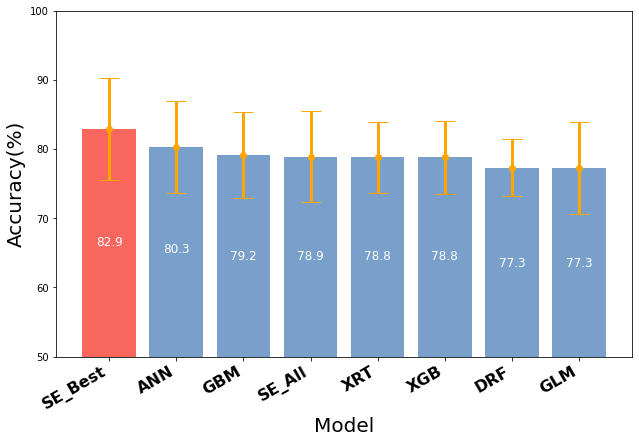

In [274]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df, 'accuracy')

In [278]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = pd.DataFrame(columns = df.columns)
    for model_family in df.model_family.unique():
        model_family_group = df[df.model_family == model_family]
        model_family_group = model_family_group.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)[:3]
        selected_model = model_family_group.sort_values(by=f'{evaluation_metrics}_std', ascending=False).iloc[0,:]
        selected_models.loc[len(selected_models),:] = selected_model
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    y = selected_models[f'{evaluation_metrics}_mean']
    x = selected_models['model_family']
    y_error = selected_models[f'{evaluation_metrics}_std']
   
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
    y_error_perc = [a*100 for a in y_error]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)

    ax.set_ylim(0,100)
#     addlabels(ax,x,y_perc)
    bars = ax.bar(x,y_perc,color=colors)
        
    ax.set_xlabel('Model', fontsize=20)
    ax.set_ylabel('ACCURACY', fontsize=20)

    ax.bar_label(bars, label_type='center',color='white', fontsize=16, fontweight='bold')

    ax.errorbar(x, y_perc, yerr=y_error_perc,
          fmt='o', color='orange', ecolor='orange',
          elinewidth = 3, capsize=10)
#     ax.errorbar(x, y, yerr=y_error,
#               fmt='o', color='orange', ecolor='orange',
#               elinewidth = 3, capsize=10)
    
#     ax.yaxis.set_tick_params(labelsize=20, fontweight='bold')
    
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=16, weight = 'bold')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

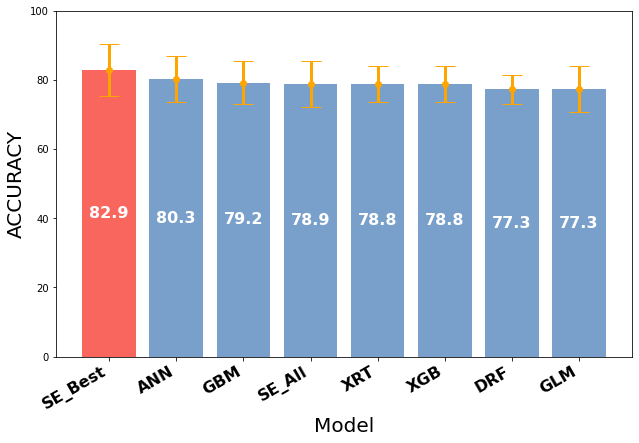

In [279]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df, 'accuracy')

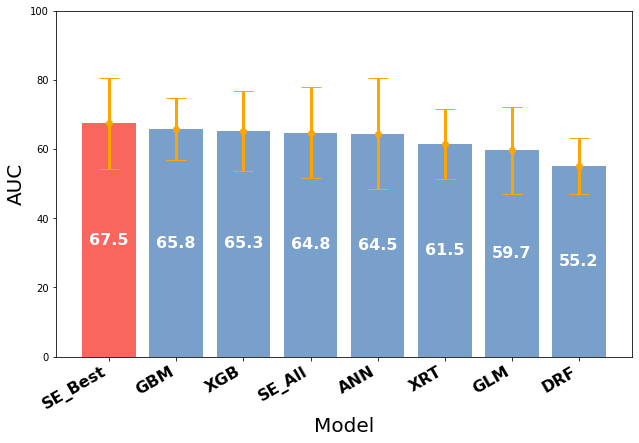

In [276]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df, 'auc')

In [258]:
def error_bar_join_plot(selected_models, evaluation_metrics, ax):
#     selected_models = pd.DataFrame(columns = df.columns)
#     for model_family in df.model_family.unique():
#         model_family_group = df[df.model_family == model_family]
#         model_family_group = model_family_group.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)[:3]
#         selected_model = model_family_group.sort_values(by=f'{evaluation_metrics}_std', ascending=False).iloc[0,:]
#         selected_models.loc[len(selected_models),:] = selected_model
#     selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
#     selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    
    y = selected_models[f'{evaluation_metrics}_mean']
    x = selected_models['model_family']
    y_error = selected_models[f'{evaluation_metrics}_std']
   
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
    y_error_perc = [a*100 for a in y_error]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]
    
#     fig, ax = plt.subplots(1,1)
#     fig.set_size_inches(10,6)

#     ax.set_ylim(50,100)
#     addlabels(ax,x,y_perc)

    bars = ax.bar(x,y_perc,color=colors)
        
    ax.set_xlabel('Model', fontsize=20)
    ax.set_ylabel(evaluation_metrics.upper(), fontsize=20)

    ax.bar_label(bars, label_type='center',color='white', fontsize=16, fontweight='bold')

    ax.errorbar(x, y_perc, yerr=y_error_perc,
          fmt='o', color='orange', ecolor='orange',
          elinewidth = 3, capsize=10)
    
#     plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=20, weight = 'bold')
    plt.setp(ax.get_xticklabels(), fontsize=16, weight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

In [259]:
evaluation_metrics = 'auc'

selected_models = pd.DataFrame(columns = df.columns)
for model_family in df.model_family.unique():
    model_family_group = df[df.model_family == model_family]
    model_family_group = model_family_group.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)[:3]
    selected_model = model_family_group.sort_values(by=f'{evaluation_metrics}_std', ascending=False).iloc[0,:]
    selected_models.loc[len(selected_models),:] = selected_model
selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
print(selected_models.columns)
# selected_models[['model_family','accuracy_mean','f1_mean','auc_mean']]
selected_models[['model_family','test_acc','test_F1','test_auc']]

Index(['challenge', 'imputation', 'model_id', 'model_family', 'ensemble',
       'metalearner', 'test_acc', 'test_F1', 'test_auc', 'test_aucpr',
       'accuracy_mean', 'auc_mean', 'err_mean', 'err_count_mean',
       'f0point5_mean', 'f1_mean', 'f2_mean', 'lift_top_group_mean',
       'logloss_mean', 'max_per_class_error_mean', 'mcc_mean',
       'mean_per_class_accuracy_mean', 'mean_per_class_error_mean', 'mse_mean',
       'pr_auc_mean', 'precision_mean', 'r2_mean', 'recall_mean', 'rmse_mean',
       'specificity_mean', 'accuracy_std', 'auc_std', 'err_std',
       'err_count_std', 'f0point5_std', 'f1_std', 'f2_std',
       'lift_top_group_std', 'logloss_std', 'max_per_class_error_std',
       'mcc_std', 'mean_per_class_accuracy_std', 'mean_per_class_error_std',
       'mse_std', 'pr_auc_std', 'precision_std', 'r2_std', 'recall_std',
       'rmse_std', 'specificity_std'],
      dtype='object')


,model_family,test_acc,test_F1,test_auc
5,SE_Best,0.675,0.640103,0.527342
2,GBM,0.658333,0.606091,0.548589
3,XGB,0.733333,0.701895,0.683734
6,SE_All,0.733333,0.64183,0.619645
0,ANN,0.508333,0.530249,0.580286
1,XRT,0.741667,0.646794,0.638802
8,GLM,0.716667,0.619444,0.597005
4,DRF,0.716667,0.619444,0.632881


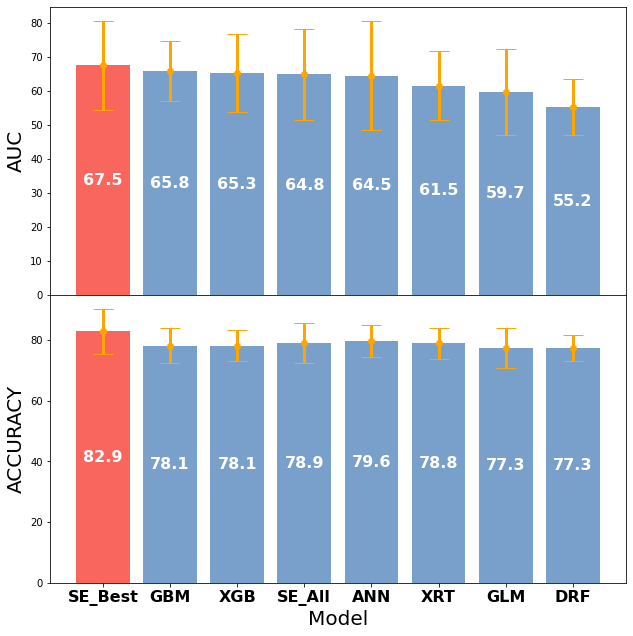

In [260]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
(ax1, ax2)  = gs.subplots(sharex='col', sharey='row')
evaluation_metrics = 'auc'

selected_models = pd.DataFrame(columns = df.columns)
for model_family in df.model_family.unique():
    model_family_group = df[df.model_family == model_family]
    model_family_group = model_family_group.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)[:3]
    selected_model = model_family_group.sort_values(by=f'{evaluation_metrics}_std', ascending=False).iloc[0,:]
    selected_models.loc[len(selected_models),:] = selected_model
selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]

error_bar_join_plot(selected_models, 'auc', ax1)
error_bar_join_plot(selected_models, 'accuracy', ax2)
# error_bar_join_plot(selected_models, 'f1', ax3)

In [204]:
def bar_plot(selected_models, evaluation_metrics):
    
    y = selected_models[evaluation_metrics]
    x = selected_models['model_family']    
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    
    ax.set_xlabel('Model', fontsize=20)
    ax.set_ylabel(evaluation_metrics.upper(), fontsize=20)

    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]
    bars = ax.bar(x, y_perc, color=colors)
    ax.bar_label(bars, label_type='center',color='white', fontsize=16, fontweight='bold')
    
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=16, weight = 'bold')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

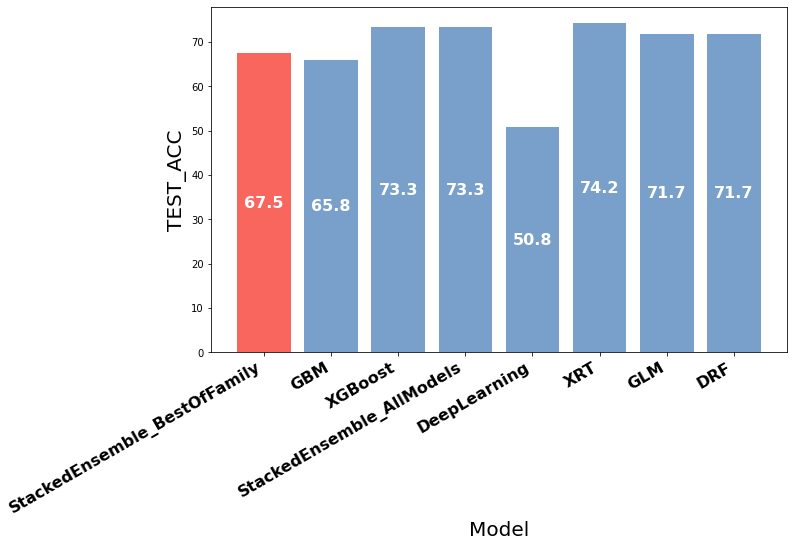

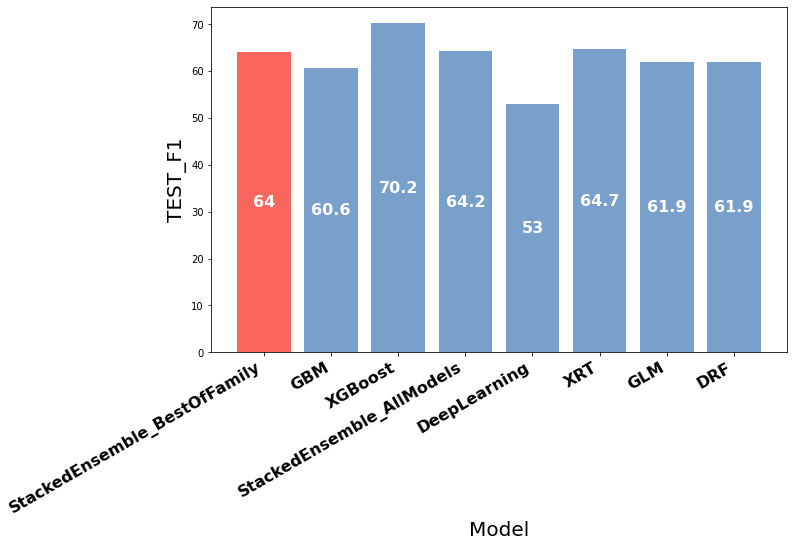

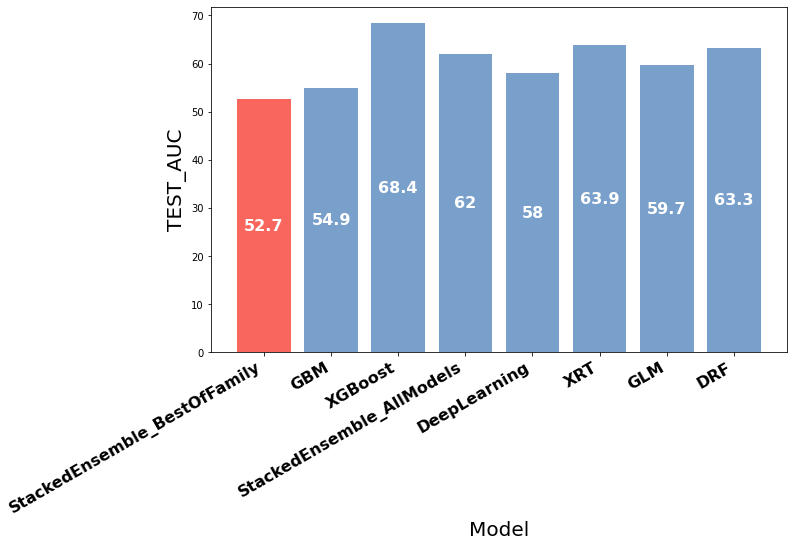

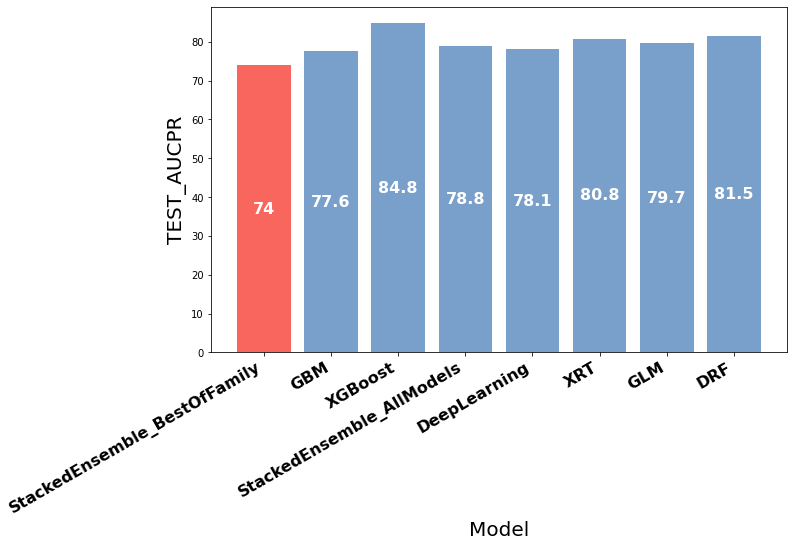

In [205]:
evaluation_metics_list = ['test_acc', 'test_F1', 'test_auc', 'test_aucpr']
selected_models = pd.DataFrame(columns = df.columns)
for model_family in df.model_family.unique():
    model_family_group = df[df.model_family == model_family]
    model_family_group = model_family_group.sort_values(by=f'auc_mean', ascending=False)[:3]
    selected_model = model_family_group.sort_values(by=f'auc_std', ascending=False).iloc[0,:]
    selected_models.loc[len(selected_models),:] = selected_model
selected_models = selected_models.sort_values(by=f'auc_mean', ascending=False)
selected_models = selected_models[~selected_models.model_family.isin(['StackedEnsemble_Best1000','StackedEnsemble_SelectedModels'])]
    
for evaluation_metics in evaluation_metics_list:
    bar_plot(selected_models, evaluation_metics)

In [ ]:
dataset = DRP_Dataset(
    library_root = 'Dataset/',
    challenge = 'binary_classification', #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset = 'CORRONA CERTAIN', 
    process_approach = 'SC', #option: KVB, SC
    imputation = None, #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group = ['bionaive TNF'], #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.8,
    remove_low_DAS = True,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
# train_h2o = h2o.upload_file(str(train_loc))
# test_h2o = h2o.upload_file(str(test_loc))
train_h2o = h2o.import_file(str(train_loc))
test_h2o = h2o.import_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = dataset.target

for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
if "classification" in dataset.challenge:
    train_h2o[y] = train_h2o[y].asfactor()
    test_h2o[y] = test_h2o[y].asfactor()

In [ ]:
# regression
evaluation_metrics = 'accuracy'
model_path_dir = '../leaderboard/model_saved/'
model_id_list = list(df_dev.loc[df_dev.groupby('model_family')[f'{evaluation_metrics}_mean'].idxmax()].reset_index(drop=True).sort_values(by=f'{evaluation_metrics}_mean',ascending=False)['model_id'].values)

for i, model_id in enumerate(model_id_list):
    model_path = os.path.join(model_path_dir,model_id)
    uploaded_model = h2o.upload_model(model_path)
    m = h2o.get_model(model_id)
#     print(m)
    regression_pred = m.predict(test_h2o).as_data_frame()['predict']
    regression_true = test_h2o.as_data_frame()[dataset.target]
    m.model_performance(test_h2o)

    X = test.drop(columns=dataset.target)
    true = test[dataset.target]
    pred = m.predict(test_h2o).as_data_frame()['predict']

    baseline = test['DAS28_CRP_0M']

    baseline, true, pred = np.array(baseline), np.array(true), np.squeeze(np.array(pred))

    print("classification accuracy", Classification_Accuracy(true,pred))
    print("F1 score", F1_Score(true,pred))

    contingency_matrix = pd.crosstab(true, pred, rownames=['true'], colnames=[
                                                 'prediction'], normalize='columns')
    plt.figure(i)
    sns.heatmap(contingency_matrix.T, annot=True,
                fmt='.2f', cmap="YlGnBu", cbar=False)
    plt.show()


# 3 Class 

In [280]:
df = pd.read_csv('../leaderboard/SC_3_Class_classification_Aug4_final_output.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: '../leaderboard/SC_3_Class_classification_Aug4_final_output.csv'

In [ ]:
df_dev = df
df_dev.loc[:,'model_family'] = df_dev.apply(lambda row:add_model_family(row),axis=1)
df_dev

In [ ]:
def addlabels(ax,x,y):
    for i in range(len(x)):
        ax.text(i, (y[i])//2, y[i], ha = 'center', color='white',fontsize=12)

In [ ]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
#     x = list(df['model_id'])
#     y = df[f'{evaluation_metrics}_mean']
    y_1 = [round(a,2) for a in y]
#     y_error = df[f'{evaluation_metrics}_std']
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'accuracy':
        ax1.set_ylim(0,100)
        bars = ax1.bar(x,y_perc,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
    addlabels(ax1,x,y_perc)
#     ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Accuracy(%)', fontsize=20)
    
    ax1.errorbar(x, y_perc, yerr=y_error_perc,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
    

In [ ]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df_dev, 'accuracy')

In [ ]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
    y_1 = [round(a,2) for a in y]
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 1 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'auc':
        ax1.set_ylim(0,1)
        bars = ax1.bar(x,y_1,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
#     addlabels(ax1,x,y_1)
    ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Area under ROC', fontsize=20)
    
    ax1.errorbar(x, y, yerr=y_error,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2)
    